In [1]:
using CSV
using DataFrames
using Plots
using LaTeXStrings
using IJulia
using LinearAlgebra
using StaticArrays
using FLoops
gr()


Plots.GRBackend()

In [6]:
function vec_triu(M::AbstractMatrix{T}) where T
    m, n = size(M)
    m == n || throw(error("not square"))
    l = n*(n+1) ÷ 2
    v = zeros(T,l)
    k = 0
    @inbounds for i in 1:n
        for j in 1:i
            v[k + j] = M[j, i]
        end
        k += i
    end
    v
end

function SSF(RA::DataFrame, RB::DataFrame; q0::Float64 = 0.001, q1::Float64 = 2.0)
    @assert size(RA) == size(RB)
    #Make array for q:
    N = 101
    Q = Array(range(q0, q1, length = N))
    
    #Define matrices for positions:
    X = transpose(repeat(RA.x,1,length(RA.x))).-repeat(RB.x,1,length(RB.x))
    Y = transpose(repeat(RA.y,1,length(RA.y))).-repeat(RB.y,1,length(RB.y))
    Z = transpose(repeat(RA.z,1,length(RA.z))).-repeat(RB.z,1,length(RB.z))
    S = zeros(N)
    for (i,q) in enumerate(Q)
        S[i] = sum(cos.(abs.(X).*q).+cos.(abs.(Y).*q).+cos.(abs.(Z).*q))/(length(RA.x)*2*3)
        
    end
        
    return S, Q
end

function SSF_2(RA::DataFrame, RB::DataFrame; k0::Float64 = 3., k1::Float64 = 9.,k_dir::Vector{Float64} = [sqrt(1/3),sqrt(1/3),sqrt(1/3)])
    @assert size(RA) == size(RB)
    #Make array for k:
    N = 100
    K = Array(range(k0, k1, length = N))
    S = zeros(N)
    for (i,k) in enumerate(K)
        for r in eachrow(RA)
            #S[i]+=(sum(cos.(abs.(RB[:,:x].-r.x)))+sum(cos.(abs.(RB[:,:y].-r.y)))+sum(cos.(q.*abs.(RB[:,:z].-r.z))))/(length(RA.x)*2)
            S[i]+=sum(cos.(((k*k_dir[1]).*abs.(RB[:,:x].-r.x)).+((k*k_dir[2]).*abs.(RB[:,:y].-r.y)).+((k*k_dir[3]).*abs.(RB[:,:z].-r.z))))
        end
    end
            
    return S, K
end

function SSF_individual_k(RA::DataFrame, RB::DataFrame,k1::Float64,k2::Float64,k3::Float64)
    # Loop over each particle and calculate the sum over all other particles
    S = 0.0
    for r in eachrow(RA)
        S+=sum(cos.((k1.*abs.(RB[:,:x].-r.x)).+(k2.*abs.(RB[:,:y].-r.y)).+(k3.*abs.(RB[:,:z].-r.z))))
    end          
    return S/(length(RA.x)*2)
end

function SSF_Matrix(X::Matrix{Float64},Y::Matrix{Float64},Z::Matrix{Float64},k1::Float64,k2::Float64,k3::Float64,len::Int64)     
    return sum(cos.(k1*X+k2*Y+k3*Z))/len
end

@fastmath function SSF_Vector(X::Vector{Float64},Y::Vector{Float64},Z::Vector{Float64},k1::Float64,k2::Float64,k3::Float64,len::Int64)     
    return sum(cos.(k1*X+k2*Y+k3*Z))/len
end

function idx_nearest(k_space::Vector{Float64},k::Float64)
    return argmin(abs.(k_space.-k))
end
    
function SSF_wrapper(RA::DataFrame, RB::DataFrame,k_df::DataFrame, k_space::Vector{Float64})
    @assert size(RA) == size(RB)
    
    # Construct the space for the k-values
    if length(k_space)<3
        k_space = Array(range(minimum(k_df.k), maximum(k_df.k),length = 100))
    end
    
    # Array to count number of samples in each bin
    num_samples = zeros(Int32,100)
    
    # Array to store the SSF of all k vector
    ssf = zeros(Float64,100)
    
    # The diff matrices:
    X = vec_triu(abs.(transpose(repeat(RA.x,1,length(RA.x))).-repeat(RB.x,1,length(RB.x))))
    Y = vec_triu(abs.(transpose(repeat(RA.x,1,length(RA.x))).-repeat(RB.x,1,length(RB.x))))
    Z = vec_triu(abs.(transpose(repeat(RA.x,1,length(RA.x))).-repeat(RB.x,1,length(RB.x))))
    x = 
    half_N = length(RA.x) #Total number of particles
    
    counter = 0
    N_tot = length(k_df.k) # Total number of k-vectors
    tic = time()
    
    # Loop over all k vectors
    for k_row in eachrow(k_df)
        bin = idx_nearest(k_space,k_row.k) #Find the correct bin
        num_samples[bin] +=1               #Increase the number of sampels in that bin
        ssf[bin] += SSF_Vector(X,Y,Z,k_row.k1,k_row.k2,k_row.k3,half_N)
        
        
        counter += 1
        if counter%10 == 0
            prog=trunc(Int, 10*counter/N_tot)
            IJulia.clear_output(true)
            print("Progress: ",repeat("▮",prog),repeat("▯",10-prog)," $(counter)/$(N_tot) $(trunc(Int, 100*counter/N_tot))%")
        end
    end
    toc = time()
    println("Time elapsed: $(toc-tic)s for $(counter) runs.")
    # Replace num_samples = 0 by 1 to avoid dividing by zero.
    num_samples[num_samples.==0] .= 1
    return k_space, ssf./num_samples
end
    
    

SSF_wrapper (generic function with 1 method)

### Read the dump file

In [3]:
N = 16000
f_path = "../Sim_results/bcc16000_v2/pos_014K.dump"
df = DataFrame(CSV.File(f_path; skipto=10, limit=N,delim = " ", header = ["id", "_type", "x", "y", "z"],ignorerepeated=true,ntasks = 1))
dfA = df[df._type.==1,:]
dfB = df[df._type.==2,:];

### Import the k-vectors and $S(\vec{k})$ from freud

In [4]:
k_df = DataFrame(CSV.File("k_points_fraud.csv"))
k_df[!,:k] = sqrt.(k_df.k1.^2+k_df.k2.^2+k_df.k3.^2) # Add a row with the length of each k-vector
Sk_df = DataFrame(CSV.File("S_k_fraud.csv"))
k_space = Array(range(minimum(k_df.k), maximum(k_df.k),length = 100));

In [5]:
bin_centers = Array([ 0.075     ,  0.22500001,  0.375     ,  0.52500004,  0.67500001,
        0.82500005,  0.97500002,  1.125     ,  1.2750001 ,  1.42499995,
        1.57500005,  1.72500014,  1.875     ,  2.0250001 ,  2.17500019,
        2.32500005,  2.47500014,  2.625     ,  2.7750001 ,  2.92500019,
        3.07500005,  3.22500014,  3.375     ,  3.5250001 ,  3.67500019,
        3.82500029,  3.97500014,  4.125     ,  4.27500057,  4.42500019,
        4.57499981,  4.72500038,  4.875     ,  5.02500057,  5.17500019,
        5.32499981,  5.47500038,  5.625     ,  5.77500057,  5.92500019,
        6.07499981,  6.22500038,  6.375     ,  6.52500057,  6.67500019,
        6.82500029,  6.97500038,  7.125     ,  7.27500057,  7.42500019,
        7.57500029,  7.72500038,  7.875     ,  8.02500057,  8.17500019,
        8.32500076,  8.47500038,  8.625     ,  8.77500057,  8.92500019,
        9.07500076,  9.22500038,  9.375     ,  9.52500057,  9.67500019,
        9.82500076,  9.97500038, 10.125     , 10.27500057, 10.42500019,
       10.57500076, 10.72500038, 10.875     , 11.02500057, 11.17500019,
       11.32500076, 11.47500038, 11.625     , 11.77500057, 11.92500019,
       12.07500076, 12.22500038, 12.375     , 12.52500057, 12.67500114,
       12.82500076, 12.97500038, 13.125     , 13.27500057, 13.42500114,
       13.57500076, 13.72500038, 13.875     , 14.02500057, 14.17500114,
       14.32500076, 14.47500038, 14.625     , 14.77500057, 14.92500114]);

### Calculate the static structure function

In [7]:
k, S_k_calculated = SSF_wrapper(dfA, dfB, sort(k_df,[:k])[1:5_000,:],bin_centers);

Progress: ▮▮▮▮▮▮▮▮▮▮ 5000/5000 100%Time elapsed: 4549.003000020981s for 5000 runs.


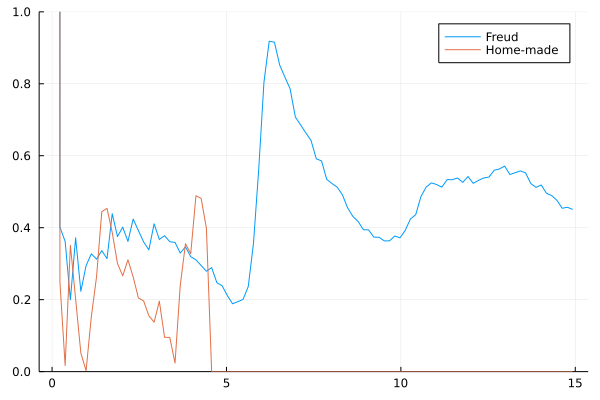

In [8]:
p1 = plot(bin_centers,Sk_df.S_k,ylim=(0,1.),grid = true,label = "Freud")
p1 = plot!(bin_centers,abs.(S_k_calculated),label = "Home-made")

In [ ]:
# The diff matrices:
X = abs.(transpose(repeat(dfA.x,1,length(dfA.x))).-repeat(dfA.x,1,length(dfA.x)))

In [ ]:
X = vec_triu(abs.(transpose(repeat(dfA.x,1,length(dfA.x))).-repeat(dfA.x,1,length(dfA.x))))

In [ ]:
Threads.nthreads()

In [ ]:
k_df